In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import os
import seaborn as sns
import statsmodels.formula.api as sm
from numpy.polynomial.polynomial import polyfit
from sklearn.model_selection import train_test_split
import sklearn
from math import sqrt
import glob

In [17]:
##import and concatenate datasets
##Mac:
# path = r'/Users/asariversjulien/Documents/Data/CSV files/Sapelo/Yearly data'

##PC:
path = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Yearly data/Flats' ##Old Flats vs Flats folder - band 6 / b5
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  ## more options can be specified also
#     print(df)

# df = df[df['Species_Code'] == 'A1'] ##eventually, you will want to do this

df

,B1,B2,B3,B4,B5,B6,B7,flats,system:index,Site,...,Quadrat_Area,Zone,Plot,Latitude,Plant_Biomass,Sample_Size,Longitude,Date,B10,B11
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0.019625,0,1,...,0.25,1,1,31.538627,516.324,23,-81.422539,10/11/2000,NaN,NaN
1,0.0339,0.0488,0.0459,0.0952,0.0691,0.2915,0.0376,0.029197,1,2,...,0.25,1,1,31.536199,1152.400,21,-81.296118,10/11/2000,NaN,NaN
2,0.0358,0.0578,0.0494,0.1039,0.0690,0.2920,0.0332,0.621180,2,3,...,0.25,1,1,31.518920,710.396,20,-81.228956,10/18/2000,NaN,NaN
3,0.0315,0.0393,0.0421,0.0773,0.0630,0.2920,0.0332,0.000368,3,4,...,0.25,1,1,31.451676,1534.304,25,-81.365498,10/10/2000,NaN,NaN
4,0.0314,0.0533,0.0495,0.1394,0.1024,0.2911,0.0549,0.002474,4,5,...,0.25,1,1,31.436090,2022.264,25,-81.339919,10/10/2000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.0193,0.0247,0.0397,0.0358,0.0885,0.0635,0.0347,0.026456,172,4,...,0.25,1,56,31.451282,820.556,12,-81.366151,10/4/2019,0.2977,0.2949
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,...,0.25,1,58,31.535648,210.604,15,-81.295100,10/11/2019,NaN,NaN
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,...,0.25,1,62,31.536196,424.300,15,-81.295883,10/11/2019,NaN,NaN
3214,0.0297,0.0381,0.0532,0.0484,0.0789,0.0530,0.0265,0.682145,175,6,...,0.25,1,64,31.388000,295.636,8,-81.279858,10/9/2019,0.2980,0.2949


In [20]:
##Bands and indices
df['Sensor'] = np.where(df['Year']<2013, 'Landsat 5', 'Landsat 8') ##make sure no other sensors are being used

df.loc[df['Year'] == 2012, 'Sensor'] = 'Landsat 7'

df['ndvi'] = np.where(df['Sensor'] == 'Landsat 8', (df['B5']-df['B4'])/(df['B5']+df['B4']), \
                      (df['B4']-df['B3'])/(df['B4']+df['B3'])) ##ndvi conditional based on whether sensor is Landsat-5 or 8

df['Blue_band'] = np.where(df['Sensor'] == 'Landsat 8', df['B2'], df['B1'])
df['Green_band'] = np.where(df['Sensor'] == 'Landsat 8', df['B3'], df['B2'])
df['Red_band'] = np.where(df['Sensor'] == 'Landsat 8', df['B4'], df['B3'])
df['NIR_band'] = np.where(df['Sensor'] == 'Landsat 8', df['B5'], df['B4'])
df['SWIR1_band'] = np.where(df['Sensor'] == 'Landsat 8', df['B6'], df['B5'])
df['SWIR2_band'] = np.where(df['Sensor'] == 'Landsat 8', df['B7'], df['B7'])

##IMPORTANT: again, these bands between landsat 5 and 8 may not be able to be compared directly

##Variables from Byrd et al. 2018 (make sure calculations are accurate):
df['savi'] = ((df['NIR_band']-df['Red_band'])*1.5)/(df['NIR_band']+df['Red_band']+0.5)
df['wdrvi5'] = (0.5*df['NIR_band']-df['Red_band'])/(0.5*df['NIR_band']+df['Red_band'])
df['nd_r_g'] = (df['Red_band']-df['Green_band'])/(df['Red_band']+df['Green_band'])
df['nd_g_b'] = (df['Green_band']-df['Blue_band'])/(df['Green_band']+df['Blue_band'])
df['nd_swir2_nir'] = (df['SWIR2_band']-df['NIR_band'])/(df['SWIR2_band']+df['NIR_band'])
df['nd_swir2_r'] = (df['SWIR2_band']-df['Red_band'])/(df['SWIR2_band']+df['Red_band'])

df

,B1,B2,B3,B4,B5,B6,B7,flats,system:index,Site,...,Red_band,NIR_band,SWIR1_band,SWIR2_band,savi,wdrvi5,nd_r_g,nd_g_b,nd_swir2_nir,nd_swir2_r
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,0.019625,0,1,...,0.0309,0.0551,0.0357,0.0289,0.061945,-0.057314,0.013115,0.052448,-0.311905,-0.033445
1,0.0339,0.0488,0.0459,0.0952,0.0691,0.2915,0.0376,0.029197,1,2,...,0.0459,0.0952,0.0691,0.0376,0.115349,0.018182,-0.030623,0.180169,-0.433735,-0.099401
2,0.0358,0.0578,0.0494,0.1039,0.0690,0.2920,0.0332,0.621180,2,3,...,0.0494,0.1039,0.0690,0.0332,0.125134,0.025160,-0.078358,0.235043,-0.515682,-0.196126
3,0.0315,0.0393,0.0421,0.0773,0.0630,0.2920,0.0332,0.000368,3,4,...,0.0421,0.0773,0.0630,0.0332,0.085244,-0.042724,0.034398,0.110169,-0.399095,-0.118194
4,0.0314,0.0533,0.0495,0.1394,0.1024,0.2911,0.0549,0.002474,4,5,...,0.0495,0.1394,0.1024,0.0549,0.195747,0.169463,-0.036965,0.258560,-0.434894,0.051724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.0193,0.0247,0.0397,0.0358,0.0885,0.0635,0.0347,0.026456,172,4,...,0.0358,0.0885,0.0635,0.0347,0.126622,0.105559,-0.051656,0.232919,-0.436688,-0.015603
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3214,0.0297,0.0381,0.0532,0.0484,0.0789,0.0530,0.0265,0.682145,175,6,...,0.0484,0.0789,0.0530,0.0265,0.072932,-0.101878,-0.047244,0.165389,-0.497154,-0.292390


<AxesSubplot:xlabel='ndvi', ylabel='Plant_Biomass'>

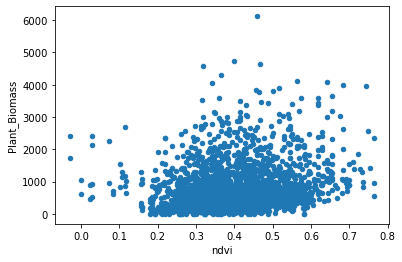

In [21]:
g = df.plot(kind = 'scatter', x = 'ndvi', y = 'Plant_Biomass')

g

# for col in df.columns:
#     print(col)

In [5]:
##DAYMET data added - yearly averages
##PC:
path2 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Yearly averages' 
all_files2 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files2:
    dm = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm)

dm = pd.concat(li, axis=0, ignore_index=True)

dm['ident'] = dm['Latitude']/dm['Longitude']

display(dm)

##Seasonal averages: growing season (defined as between 3/1 and 10/31)
path3 = r'C:/Users/arj26323/Documents/Data/Biomass datasets/Daymet/GA/Growing season' 
all_files3 = glob.glob(path2 + "/*.csv")

li = []

for filename in all_files3:
    dm2 = pd.read_csv(filename, index_col=None, header=0)
    li.append(dm2)

dm2 = pd.concat(li, axis=0, ignore_index=True)

dm2['ident'] = dm2['Latitude']/dm2['Longitude']

dm2 = dm2.rename(
    columns=
    {
        'dayl': 'sn_dayl', 'prcp': 'sn_prcp', 'srad': 'sn_srad','tmax': 'sn_tmax','tmin': 'sn_tmin','vp': 'sn_vp',
        'swe': 'sn_swe'
    }
)

display(dm2)

,dayl,prcp,srad,swe,tmax,tmin,vp,system:index,Site,Species_Code,Year,Quadrat_Area,Zone,Plot,Latitude,Plant_Biomass,Sample_Size,Longitude,Date,ident
0,43200.085938,2.568438,342.593597,0.0,25.048056,14.132274,1776.901489,0,1,A1,2000,0.25,1,1,31.538627,516.324,23,-81.422539,10/11/2000,-0.387345
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,A1,2000,0.25,1,1,31.536199,1152.400,21,-81.296118,10/11/2000,-0.387918
2,43200.085938,2.319699,336.004730,0.0,24.539864,15.079507,1874.970703,2,3,A1,2000,0.25,1,1,31.518920,710.396,20,-81.228956,10/18/2000,-0.388026
3,43200.085938,2.472329,340.215027,0.0,24.868795,14.635425,1827.156250,3,4,A1,2000,0.25,1,1,31.451676,1534.304,25,-81.365498,10/10/2000,-0.386548
4,43200.085938,2.445726,340.010864,0.0,24.818274,14.757424,1839.845947,4,5,A1,2000,0.25,1,1,31.436090,2022.264,25,-81.339919,10/10/2000,-0.386478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,43219.992188,3.616016,331.420837,0.0,26.539396,16.000111,1951.389526,172,4,A1,2019,0.25,1,56,31.451282,820.556,12,-81.366151,10/4/2019,-0.386540
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,A1,2019,0.25,1,58,31.535648,210.604,15,-81.295100,10/11/2019,-0.387916
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,A1,2019,0.25,1,62,31.536196,424.300,15,-81.295883,10/11/2019,-0.387919
3214,43219.945312,3.418571,331.718445,0.0,26.426649,16.417061,1985.196167,175,6,A1,2019,0.25,1,64,31.388000,295.636,8,-81.279858,10/9/2019,-0.386172


,sn_dayl,sn_prcp,sn_srad,sn_swe,sn_tmax,sn_tmin,sn_vp,system:index,Site,Species_Code,Year,Quadrat_Area,Zone,Plot,Latitude,Plant_Biomass,Sample_Size,Longitude,Date,ident
0,43200.085938,2.568438,342.593597,0.0,25.048056,14.132274,1776.901489,0,1,A1,2000,0.25,1,1,31.538627,516.324,23,-81.422539,10/11/2000,-0.387345
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,A1,2000,0.25,1,1,31.536199,1152.400,21,-81.296118,10/11/2000,-0.387918
2,43200.085938,2.319699,336.004730,0.0,24.539864,15.079507,1874.970703,2,3,A1,2000,0.25,1,1,31.518920,710.396,20,-81.228956,10/18/2000,-0.388026
3,43200.085938,2.472329,340.215027,0.0,24.868795,14.635425,1827.156250,3,4,A1,2000,0.25,1,1,31.451676,1534.304,25,-81.365498,10/10/2000,-0.386548
4,43200.085938,2.445726,340.010864,0.0,24.818274,14.757424,1839.845947,4,5,A1,2000,0.25,1,1,31.436090,2022.264,25,-81.339919,10/10/2000,-0.386478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,43219.992188,3.616016,331.420837,0.0,26.539396,16.000111,1951.389526,172,4,A1,2019,0.25,1,56,31.451282,820.556,12,-81.366151,10/4/2019,-0.386540
3212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173,2,A1,2019,0.25,1,58,31.535648,210.604,15,-81.295100,10/11/2019,-0.387916
3213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,174,2,A1,2019,0.25,1,62,31.536196,424.300,15,-81.295883,10/11/2019,-0.387919
3214,43219.945312,3.418571,331.718445,0.0,26.426649,16.417061,1985.196167,175,6,A1,2019,0.25,1,64,31.388000,295.636,8,-81.279858,10/9/2019,-0.386172


In [6]:
##Merging elevation point data with band dataset prior to model development

elev_10m = pd.read_csv('C:/Users/arj26323/Documents/Data/Biomass datasets/Sapelo/Point_elevation/DEM_vals_10m.csv')

elev_10m.rename(columns={'first':'Elevation'}, inplace=True)

# elev_10m = elev_10m.drop_duplicates(subset=['Latitude'])

print(elev_10m.groupby(['Latitude','Longitude']).size())

print(len(df['Latitude'].unique()))
print(len(df['Longitude'].unique()))
print(len(elev_10m['Latitude'].unique()))
print(len(elev_10m['Longitude'].unique()))

## drop rows which have same lat and long and keep latest entry
dfx = elev_10m.drop_duplicates(
  subset = ['Latitude', 'Longitude'],
  keep = 'last').reset_index(drop = True)

dfx = dfx[['Elevation', 'Latitude', 'Longitude']]
dfx['ident'] = dfx['Latitude']/dfx['Longitude'] ##Weird work around, but it works - check df comparison excel sheet

df['ident'] = df['Latitude']/df['Longitude'] ##Look at merging on multiple columns to test this

##Rationale on the 'ident' column: there are 208 unique lat/long combinations (ie locations), yet only 203 unique lats and \
##longs (some repeat, but no repeat combinations!). This 'ident' identifies unique combinations of lats and longs and can \
##be used to merge/sort the dataframes accordingly. To confirm the results, look at df_comparison excel sheet (in onedrive)

## print latest dataframe
# display(dfx)

print(len(dfx['Latitude'].unique()))
print(len(dfx['Longitude'].unique()))
print(len(dfx['ident'].unique()))
print(len(df['ident'].unique()))

# print(elev_10m)
# print(dfx)

df0 = pd.merge(df, dfx, on = 'ident') ##seems to work; check out comparison excel sheet
df0_sn = pd.merge(df0, dm2)
df1 = pd.merge(df0_sn, dm)

display(df1)
# display(df0)

out_dir = os.path.expanduser('~/Downloads')
out_csv = os.path.join(out_dir, 'ga_df1.csv')
# df1.to_csv(out_csv, index = False)

# for col in dfx.columns:
#     print(col)

Latitude   Longitude 
31.307529  -81.415324    20
31.307562  -81.415389    19
31.307641  -81.415468    19
31.307682  -81.415608    14
31.307693  -81.415592     5
                         ..
31.539429  -81.422410    19
31.539457  -81.422250    19
31.539480  -81.422098    19
31.539491  -81.421750    19
31.539505  -81.421937    19
Length: 208, dtype: int64
203
203
203
203
203
203
208
208


,B1,B2,B3,B4,B5,B6,B7,flats,system:index,Site,...,sn_vp,Latitude,Longitude,dayl,prcp,srad,swe,tmax,tmin,vp
0,0.0271,0.0301,0.0309,0.0551,0.0357,0.2911,0.0289,1.962532e-02,0,1,...,1776.901489,31.538627,-81.422539,43200.085938,2.568438,342.593597,0.0,25.048056,14.132274,1776.901489
1,0.0263,0.0404,0.0351,0.0745,0.0697,0.2883,0.0448,3.365279e-02,0,1,...,1762.035522,31.538627,-81.422539,43220.082031,2.596593,342.510712,0.0,25.575659,14.795082,1762.035522
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,...,1892.155762,31.538627,-81.422539,43220.082031,3.840604,335.109985,0.0,25.630302,15.120659,1892.155762
3,0.0344,0.0429,0.0374,0.0798,0.0649,0.2951,0.0362,9.554679e-02,0,1,...,1778.461426,31.538627,-81.422539,43200.085938,3.297945,340.148438,0.0,25.406548,14.338548,1778.461426
4,0.0240,0.0361,0.0321,0.0872,0.0559,0.2947,0.0309,4.947110e-02,0,1,...,1799.670776,31.538627,-81.422539,43220.082031,4.259862,338.359924,0.0,25.079752,14.206429,1799.670776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,0.0276,0.0341,0.0453,0.0418,0.0864,0.0560,0.0294,1.522213e-01,171,6,...,2019.184692,31.388000,-81.279858,43219.945312,3.738269,330.129822,0.0,26.283407,16.611759,2019.184692
3212,0.0249,0.0324,0.0492,0.0432,0.0930,0.0676,0.0334,1.794927e-01,166,6,...,2002.115845,31.388000,-81.279858,43219.945312,3.758626,326.138000,0.0,25.613874,16.008654,2002.115845
3213,0.0297,0.0381,0.0532,0.0484,0.0789,0.0530,0.0265,6.821449e-01,175,6,...,1985.196167,31.388000,-81.279858,43219.945312,3.418571,331.718445,0.0,26.426649,16.417061,1985.196167
3214,0.0468,0.0489,0.0573,0.0643,0.1862,0.1990,0.1136,1.443987e-07,113,8,...,1946.075684,31.308979,-81.415683,43219.898438,3.972225,327.009491,0.0,25.753296,15.542802,1946.075684


In [7]:
##First go at machine learning, using the methods of Byrd et al 2018

##Random Forest test! REMEMBER: by combining landsat 5 and 8 bands, you are grouping bands with slightly different wavelengths. 
##ONLY INDICES to account for this

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['prcp'].notna()] ##CAREFUL; added 7/11/22
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here
df1 = df1[(df1['flats'] < 0.1)] ##TIDAL FILTERING STEP! Increases NRMSE, but seems to be a better fit

from sklearn.model_selection import train_test_split
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime

df1['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
df1['DOY'] = df1['Date'].dt.strftime('%j') ##Add day of year (DOY) to dataset
# df1['DOY'] = df1['Date'].dt.strftime('%j').astype('float') ##The astype('float') is only for the regression - not for ML 

xargs=df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','wdrvi5', 'savi', 
        'Elevation', 'tmax', 'tmin', 'sn_tmax', 'sn_tmin', 'DOY' 
    ]
]

yargs=df1['Plant_Biomass'] 

#removed: 'nd_r_g','dayl','sn_prcp', 'sn_dayl', 'sn_srad', 'sn_vp', 'vp', 'srad', 'prcp'

##Include lag variables (e.g. lag ndvi), precip, temp, more

##ELEVATION NEEDS TO BE TRIPLE-CHECKED AT EACH PLOT TO MAKE SURE VALUES CORRESPOND

size_x = 0.2
seed = 1
xargs_train, xargs_test, yargs_train, yargs_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed) 
## 80% training and 20% test

In [8]:
# TODO

# Baselines:
# - PCA in pipeline
# - means/sd with different 
# - KNN regressor: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
# - Treat as classification for new model
# - Error metrics for telling how well the model works
# - Cross validation: leave one group out (LOGO) - look this up - be careful with nearest neighbor and grouping by site
# - LOGO: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html

# # Pipeline example:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import metrics
pipe = Pipeline([('scaler', StandardScaler()), ('forest', RandomForestRegressor(n_estimators=100, random_state=seed))])
pipe.fit(xargs_train, yargs_train)
y_pred=pipe.predict(xargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(yargs_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred)))
r_square = metrics.r2_score(yargs_test, y_pred)
print("The r squared is: " + str(r_square))
print(r_square)
print('testing r2 is: ' + str(pipe.score(xargs_test, yargs_test)))
print('training r2 is: ' + str(pipe.score(xargs_train, yargs_train)))
print('NRMSE is: ' + str(np.sqrt(metrics.mean_squared_error(yargs_test, y_pred))/np.ptp(yargs_test)))

# Mean
print('MEAN BASELINE:')
y_pred_mean = [np.mean(yargs_train)] * len(yargs_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(yargs_test, y_pred_mean))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(yargs_test, y_pred_mean)))

# NDVI

print('NDVI BASELINE: unfinished')


Mean Absolute Error: 280.44775055118106
Mean Squared Error: 154805.27481083813
Root Mean Squared Error: 393.4530147436135
The r squared is: 0.4713759268379233
0.4713759268379233
testing r2 is: 0.4713759268379233
training r2 is: 0.911352336336928
NRMSE is: 0.12995335479673115
MEAN BASELINE:
Mean Absolute Error: 396.0509008713496
Root Mean Squared Error: 541.1688072580049
NDVI BASELINE: unfinished


In [9]:
# plt.scatter(xargs,yargs, color='red') ##plotting real points
# df['Plant_Biomass'].describe()

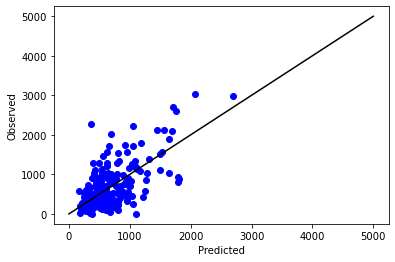

test data correlation coefficient is: 0.6872642667137104
train data correlation coefficient is: 0.9702905468476347


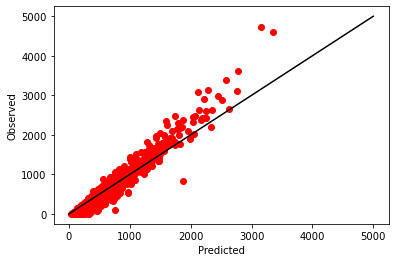

In [10]:
plt.scatter(y_pred, yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 5000], [0, 5000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(yargs_test, y_pred)[0, 1]))

train_pred = pipe.predict(xargs_train) ##Not sure if this is the right thing to do here
plt.scatter(train_pred, yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 5000], [0, 5000], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(train_pred, yargs_train)[0, 1]))

In [11]:
plt.scatter(y_xg_pred, y_xg_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.show()

np.corrcoef(y_xg_test, y_xg_pred)[0, 1]

NameError: name 'y_xg_pred' is not defined

In [12]:
##k-fold cross validation; random forest

predictors = df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b','wdrvi5', 'savi', 
        'Elevation', 'tmax', 'tmin', 'sn_tmax', 'sn_tmin', 'DOY' 
    ]
]

targets = df1['Plant_Biomass'] 

from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import KFold, cross_validate
from sklearn.datasets import load_boston

X, y = predictors, targets
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

model = pipe
scoring=('r2', 'neg_root_mean_squared_error')

cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring, return_train_score=False)
cv_results

##from: https://stackoverflow.com/questions/55270431/how-to-correctly-perform-cross-validation-in-scikit-learn

{'fit_time': array([0.56144905, 0.62377882, 0.56812263, 0.57802248, 0.55523157]),
 'score_time': array([0.01096988, 0.01296592, 0.        , 0.01562023, 0.02293873]),
 'test_r2': array([0.41322378, 0.40834807, 0.50820993, 0.31119379, 0.33981157]),
 'test_neg_root_mean_squared_error': array([-388.12305717, -319.58609485, -414.67667901, -483.71897408,
        -527.84656021])}

In [13]:
##Comparing with standard empirical model -- just uncomment and run

##sklearn - linear_regressor L1 weights look at these

print(len(xargs))
print(len(yargs))

print(xargs.head())

from sklearn import linear_model
import statsmodels.api as sm

# regr = linear_model.LinearRegression()
# regr.fit(xargs, yargs)

# print('Intercept: \n', regr.intercept_)
# print('Coefficients: \n', regr.coef_)

# with statsmodels
xargs = sm.add_constant(xargs) ##adding a constant
 
model = sm.OLS(yargs, xargs).fit()
predictions = model.predict(xargs) 
 
print_model = model.summary()
print(print_model) ##check model assumptions

1267
1267
       ndvi  nd_swir2_r  nd_swir2_nir    nd_g_b    wdrvi5      savi  \
0  0.281395   -0.033445     -0.311905  0.052448 -0.057314  0.061945   
1  0.359489    0.121402     -0.248952  0.211394  0.029717  0.096949   
3  0.361775   -0.016304     -0.375862  0.109961  0.032342  0.103046   
4  0.461861   -0.019048     -0.476715  0.201331  0.151915  0.133457   
5  0.291521    0.002453     -0.289275  0.022876 -0.046312  0.112020   

   Elevation       tmax       tmin    sn_tmax    sn_tmin  DOY  
0   0.489376  25.048056  14.132274  25.048056  14.132274  285  
1   0.489376  25.575659  14.795082  25.575659  14.795082  285  
3   0.489376  25.406548  14.338548  25.406548  14.338548  284  
4   0.489376  25.079752  14.206429  25.079752  14.206429  284  
5   0.489376  26.066071  14.187940  26.066071  14.187940  286  


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
##Some more plots

# sorted(sklearn.metrics.SCORERS.keys())

np.cov(xargs)

In [ ]:
##xgboost - seems to perform worse than random forest, at least with initial data
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## split data into X and y
xargs=df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp'
    ]
]

yargs=df1['Plant_Biomass'] 

## split data into train and test sets
size_x = 0.2
seed = 0
x_xg_train, x_xg_test, y_xg_train, y_xg_test = train_test_split(xargs, yargs, test_size=size_x, random_state = seed)

##Feature Scaling 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_xg_train = sc.fit_transform(x_xg_train)
x_xg_test = sc.transform(x_xg_test)

##fit model no training data
xg_reg = XGBClassifier()
xg_reg.fit(x_xg_train, y_xg_train)

##make predictions for test data
y_xg_pred = xg_reg.predict(x_xg_test)
# predictions = [round(value) for value in y_pred]

##evaluate predictions

from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_xg_test, y_xg_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_xg_test, y_xg_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_xg_test, y_xg_pred)))

r_square = metrics.r2_score(y_xg_test, y_xg_pred)
print(r_square)
# print(reg_x.score(x_xg_test, y_xg_test))

# accuracy = accuracy_score(yargs_test, predictions)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
print(len(xargs_test))
print(len(xargs_train))


RMSE value for k=  1 is: 556.3925722585096
RMSE value for k=  2 is: 483.684641478797
RMSE value for k=  3 is: 497.11278677027883
RMSE value for k=  4 is: 494.34701161659694
RMSE value for k=  5 is: 467.53230830639313
RMSE value for k=  6 is: 448.4512600487118
RMSE value for k=  7 is: 426.583537019132
RMSE value for k=  8 is: 425.98895110068895
RMSE value for k=  9 is: 419.70592634349435
RMSE value for k=  10 is: 419.29213048367245
RMSE value for k=  11 is: 417.0649820667257
RMSE value for k=  12 is: 415.9444720686943
RMSE value for k=  13 is: 417.40937400698397
RMSE value for k=  14 is: 414.8888374092503
RMSE value for k=  15 is: 415.9814146894502
RMSE value for k=  16 is: 417.68060923084147
RMSE value for k=  17 is: 419.07531915630824
RMSE value for k=  18 is: 422.630863707876
RMSE value for k=  19 is: 420.27544507432464
RMSE value for k=  20 is: 420.06400075374813


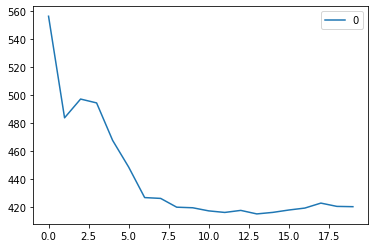

In [14]:
##KNN - be careful of site bias!! Data are spatially clustered based on site, also temporally clustered based on year

##Careful of overlap in variable names!

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

df1 = df1[df1['ndvi'].notna()] ##remove rows with NaN for columns used in the model 
df1 = df1[df1['Species_Code'] == 'A1'] ##careful here

from sklearn.metrics import accuracy_score
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

k_xargs=df1[
    [
        'ndvi', 'nd_swir2_r', 'nd_swir2_nir', 'nd_g_b', 'nd_r_g', 'wdrvi5', 'savi', 'Elevation','prcp', 'dayl', 'tmax', 'tmin',
        'srad', 'vp', 'sn_prcp', 'sn_dayl', 'sn_tmax', 'sn_tmin', 'sn_srad', 'sn_vp'
    ]
]

##Include lag variables (e.g. lag ndvi), precip, temp, more

k_yargs=df1['Plant_Biomass'] 

size_x = 0.2
seed = 0

k_xargs_train, k_xargs_test, k_yargs_train, k_yargs_test = train_test_split(
    k_xargs, k_yargs, test_size=size_x, random_state = seed
)

## 80% training and 20% test

## Feature Scaling - does something weird with k values, what does that mean? Use minmax scaler instead (below), as in example?

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
k_xargs_train = scaler.fit_transform(k_xargs_train)
k_xargs_test = scaler.fit_transform(k_xargs_test)

rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    k_model = neighbors.KNeighborsRegressor(n_neighbors = K)

    k_model.fit(k_xargs_train, k_yargs_train)  #fit the model
    k_pred=k_model.predict(k_xargs_test) #make prediction on test set
    k_error = sqrt(mean_squared_error(k_yargs_test, k_pred)) #calculate rmse
    rmse_val.append(k_error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', k_error)
    
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot() 

k_predict = k_model.predict(k_xargs_test)
##from: https://www.analyticsvidhya.com/blog/2018/08/k-nearest-neighbor-introduction-regression-python/


RMSE for KNN is: 425.98895110068895


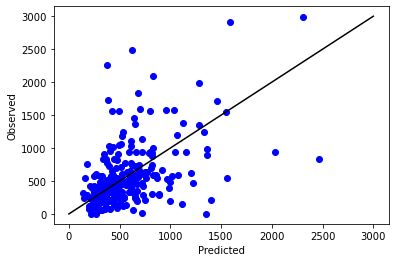

test data correlation coefficient is: 0.49237689160405107
train data correlation coefficient is: 0.6985320059388492


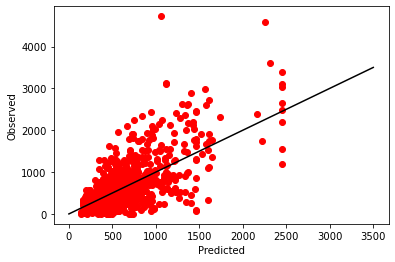

In [15]:
##KNN test results, plotted (careful of variable names overlap)
k_model = neighbors.KNeighborsRegressor(n_neighbors = 8)
k_model.fit(k_xargs_train, k_yargs_train)  #fit the model
k_pred=k_model.predict(k_xargs_test) #make prediction on test set
k_error = sqrt(mean_squared_error(k_yargs_test, k_pred))
print('RMSE for KNN is: ' + str(k_error))

plt.scatter(k_pred, k_yargs_test, color = 'blue') ##label axes - x,y in order?
# plt.plot(X_val, regressor.predict(X_val), color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3000], [0, 3000], 'k-')
plt.show()

print('test data correlation coefficient is: ' + str(np.corrcoef(k_yargs_test, k_pred)[0, 1]))

k_train_pred = k_model.predict(k_xargs_train) 
plt.scatter(k_train_pred, k_yargs_train, color = 'red')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.plot([0, 3500], [0, 3500], 'k-')
plt.show

print('train data correlation coefficient is: ' + str(np.corrcoef(k_train_pred, k_yargs_train)[0, 1]))

##Odd that the training data is not better

In [16]:
xxxx = df1[df1['Sensor'] == "Landsat 8"]
print(min(xxxx['flats']))

2.8592096046331505e-07
